# Pregunta 2

In [1]:
import numpy as np
import sgtpy as vr
import epcsaftpy as pc

comp2_name = 'm-xylene'
path_pc = './parameters/gross2001.json'
path_exp = './data_exp/DataCO2_mXyl.txt'
Pf = 12000000 # Pa

In [3]:
CO2 = pc.component('carbon dioxide', pure_path = path_pc)
comp2 =  pc.component(comp2_name, pure_path = path_pc)
mix = CO2 + comp2
saft_pc = pc.pcsaft(mix)
mix.printParameters()

print('\n Critical point calculation 1 success: ',saft_pc.pure_eos[0].critical)
if saft_pc.pure_eos[0].critical:
    print(f' * Critical temperature : {round(saft_pc.pure_eos[0].Tc,4)} K')
    print(f' * Critical pressure    : {round(saft_pc.pure_eos[0].Pc * 1e-5,2)} bar')
    print(f' * Critical density     : {round(saft_pc.pure_eos[0].rhoc * 1e-3,4)} kmol/m^3')

print('\n Critical point calculation 2 success: ',saft_pc.pure_eos[1].critical)
if saft_pc.pure_eos[1].critical:
    print(f' * Critical temperature : {round(saft_pc.pure_eos[1].Tc,4)} K')
    print(f' * Critical pressure    : {round(saft_pc.pure_eos[1].Pc * 1e-5,2)} bar')
    print(f' * Critical density     : {round(saft_pc.pure_eos[1].rhoc * 1e-3,4)} kmol/m^3')

component,Mw,$ms$,$\sigma$,$\epsilon / k_B $,reference
carbon dioxide,44.010,2.0729,2.7852,169.21,parameters/gross2001.json
m-xylene,106.167,3.1861,3.7563,283.98,parameters/gross2001.json



 Critical point calculation 1 success:  True
 * Critical temperature : 310.2768 K
 * Critical pressure    : 80.64 bar
 * Critical density     : 10.0236 kmol/m^3

 Critical point calculation 2 success:  True
 * Critical temperature : 633.8813 K
 * Critical pressure    : 42.76 bar
 * Critical density     : 2.6269 kmol/m^3


In [4]:
# Read the experimental data from a .txt file
T_exp, x1_exp, P_exp = np.loadtxt(path_exp, unpack=True)
T_list = np.unique(T_exp)
n_T = len(T_list)

### Resolviendo para PC-SAFT (a)
Primero, se modelan los datos experimentalmente sin ajuste de $k_{ij}$

In [4]:

# Solving the bubble point pressure for each temperature
saft = saft_pc
x10 = 0.04
x1f = 0.9
n = 301
x1j = np.linspace(x10, x1f, n)

y1 = []
x1 = []
P = []


yzero = 1e-3
y_guess = np.array([1. - yzero, yzero])
v0_guess = [None, None]
Xass0_guess = [None, None]


for i in range(n_T):
    Ti = T_list[i]
    y0 = y_guess.copy()
    P0 , vl, vv = saft.pure_eos[1].psat(Ti)
    v0 = [vl, vv]
    Xass0 = Xass0_guess

    P_T = [P0 * 1e-5]
    x1_T = [0]
    y1_T = [0]

    # Iterating over the liquid mole fraction
    for j in range(n):
        x = np.array([x1j[j], 1 - x1j[j]])
        out = vr.equilibrium.bubblePy(y0, P0, x, Ti, saft, good_initial=False,
                    v0 = v0, Xass0 = Xass0, full_output=True)
        if out.error < 1e-8:
            y0 = out.Y
            x0 = out.X
            P0 = out.P
            v0 = [out.v1, out.v2]
            Xass0 = [out.Xassl, out.Xassv]
            P_T.append(P0 * 1e-5)
            x1_T.append(x[0])
            y1_T.append(y0[0])
        else:
            break
        if j == 0:
            y_guess = y0.copy()
        if P0 > Pf:
            break

    # Iterating over the pressure
    k = 0
    dP = 5.*1e5
    P0 -= dP
    tol = 1e-6
    nacc = 5
    K_tol = 1e-8
    while P0 < Pf and k < 1000:
        k += 1
        P0 += dP
        z = (x0 + y0)/2
        out_flash = vr.equilibrium.flash(x0, y0, 'VL', z, Ti, P0, saft, v0 = v0, Xass0 = Xass0, full_output=True, nacc = nacc, K_tol=K_tol)

        if out_flash.error < tol:
            y0 = out_flash.Y
            x0 = out_flash.X
            v0 = [out_flash.v1, out_flash.v2]
            Xass0 = [out_flash.Xass1, out_flash.Xass2]
            P_T.append(P0 * 1e-5)
            x1_T.append(x0[0])
            y1_T.append(y0[0])
            if abs(v0[0] - v0[1])/v0[1] < 1e-3 and abs(x0[0] - y0[0]) < 1e-2:
                break
        else:
            tol *= 2
            tol = min(1e-5, tol)
            K_tol /= 2
            K_tol = max(1e-10, K_tol)
            nacc += 1
            naac = min(15, nacc)
            dP *= 0.5
            P0 -= dP
            dP = max(dP, 1e4)
    P.append(P_T)
    x1.append(x1_T)
    y1.append(y1_T)

                


out_pc = {'x1': x1, 'y1': y1, 'P': P}

c:\Users\felip\AppData\Local\Programs\Python\Python311\Lib\site-packages\sgtpy\equilibrium\flash.py:336: RuntimeWarning: divide by zero encountered in divide
  bmin = max(np.hstack([((K*Z-1.)/(K-1.))[K > 1], Z[not_in_x], 0.]))
c:\Users\felip\AppData\Local\Programs\Python\Python311\Lib\site-packages\sgtpy\equilibrium\flash.py:337: RuntimeWarning: divide by zero encountered in divide
  bmax = min(np.hstack([((1.-Z)/(1.-K))[K < 1], 1.]))
c:\Users\felip\AppData\Local\Programs\Python\Python311\Lib\site-packages\sgtpy\equilibrium\flash.py:53: RuntimeWarning: invalid value encountered in scalar divide
  dbeta = - (2*fo*dfo)/(2*dfo**2-fo*d2fo)
c:\Users\felip\AppData\Local\Programs\Python\Python311\Lib\site-packages\sgtpy\equilibrium\flash.py:407: RuntimeWarning: divide by zero encountered in divide
  bmin = max(np.hstack([((K*Z-1.)/(K-1.))[K > 1], Z[not_in_x], 0.]))
c:\Users\felip\AppData\Local\Programs\Python\Python311\Lib\site-packages\sgtpy\equilibrium\flash.py:408: RuntimeWarning: divide b

# Plotting

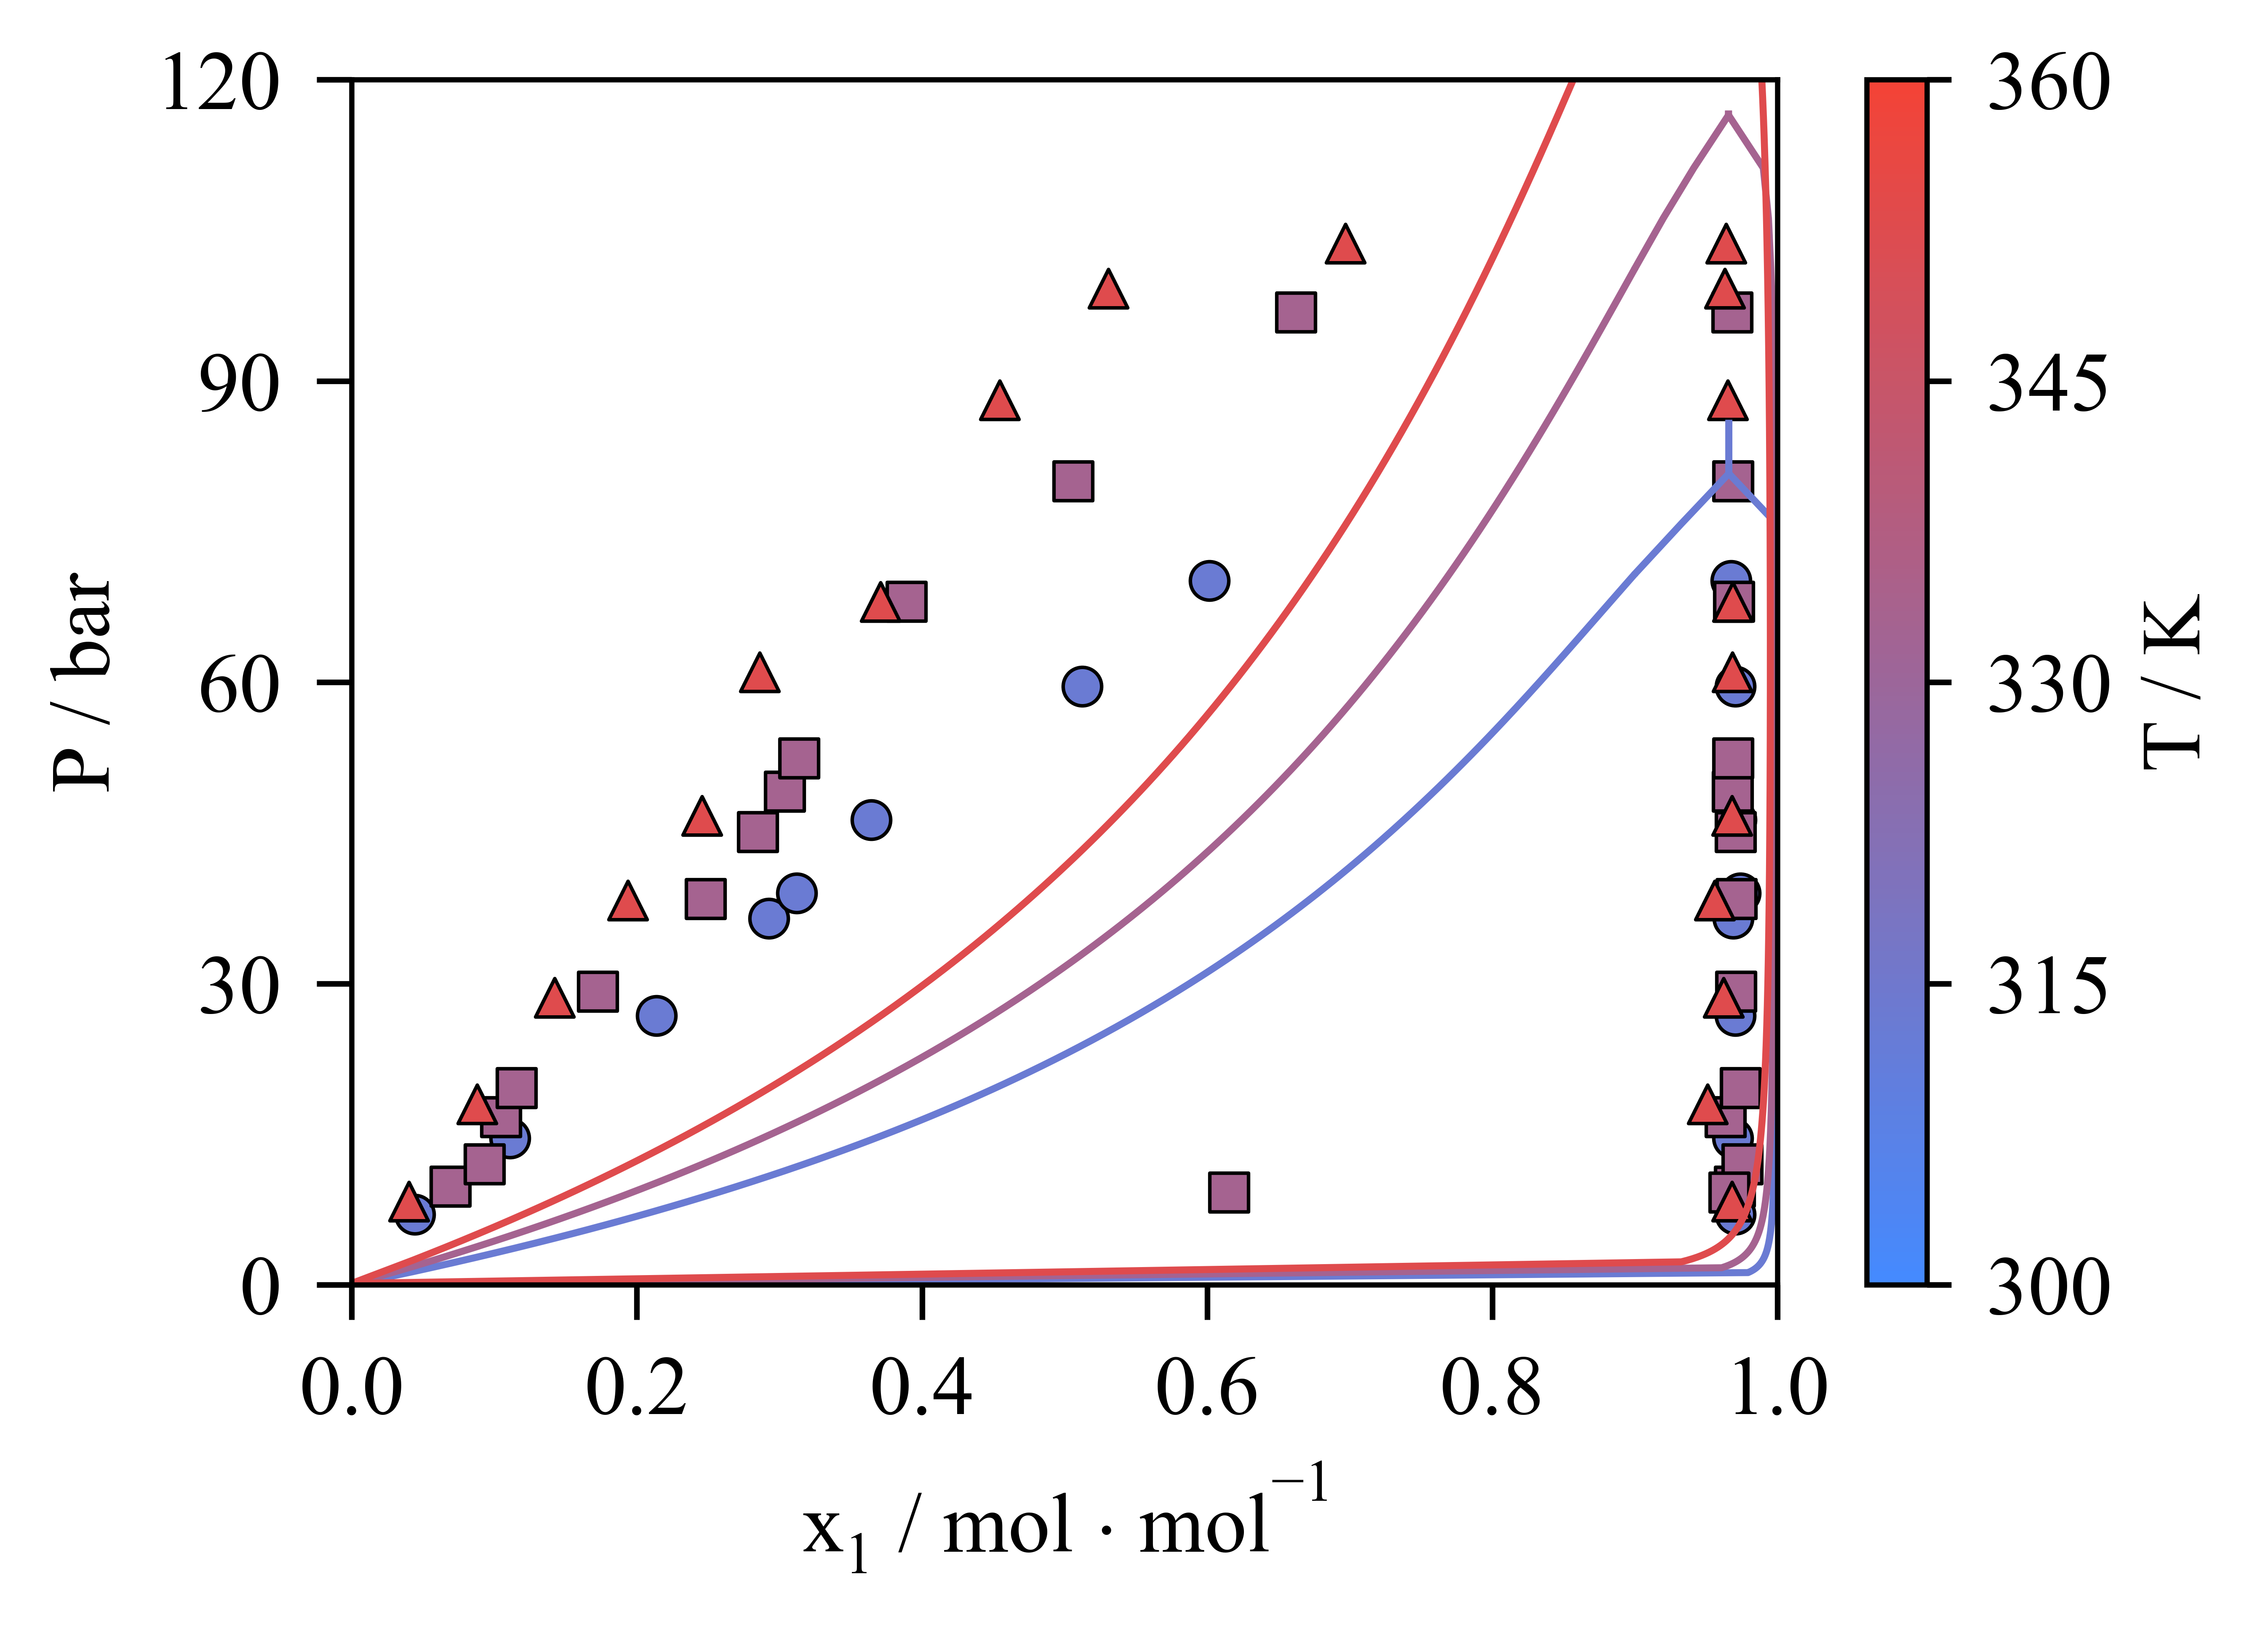

In [5]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
import matplotlib.colors as mcolors

def hex_to_RGB(hex_str):
    """ #FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]

def get_color_gradient(c1, c2, n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    """
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]
 
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Times New Roman'
matplotlib.rcParams['mathtext.it'] = 'Times New Roman'
matplotlib.rcParams['mathtext.bf'] = 'Times New Roman'
matplotlib.rcParams['xtick.major.pad']='5'
matplotlib.rcParams['ytick.major.pad']='5'
matplotlib.rcParams['axes.linewidth'] = 0.75
matplotlib.rcParams['axes.axisbelow'] = True
matplotlib.rcParams['savefig.dpi'] = 1200

font = {'weight' : 'normal', 'size'   : 12, 'family' : "Times New Roman"}
plt.rc('font', **font)
plt.rc('axes', titlesize=font["size"])


color1 = '#448AFF'
color2 = "#F44336"

Tmin = round(min(T_list)/10/2 - 0.5,0) * 10 * 2
Tmax = round(max(T_list)/10/2 + 0.5,0) * 10 * 2

n = int(Tmax - Tmin + 1)
colors = get_color_gradient(color1, color2, n)


cmap = mcolors.LinearSegmentedColormap.from_list('mycmap', colors)
data = np.random.rand(10, 10)
fig, ax = plt.subplots()
im = ax.imshow(data, cmap=cmap, vmin=Tmin, vmax=Tmax)
cb = plt.colorbar(im, ax=ax)
cb.ax.tick_params(colors='black', labelsize=12)
plt.close()

 
symbols = ['o', 's', '^', 'D']

fig, ax = plt.subplots( figsize=(3.93701 + 0.5, 3.1496), dpi=1200)


for i in range(n_T):
    color = colors[int(T_list[i] - Tmin)]
    ax.plot(out_pc["x1"][i], out_pc["P"][i], color = color, linewidth = 1.)
    ax.plot(out_pc["y1"][i], out_pc["P"][i], color = color, linewidth = 1.)
    ax.scatter(x1_exp[T_exp == T_list[i]], P_exp[T_exp == T_list[i]], 
               color = color, marker = symbols[i], linewidth=0.5, edgecolor='k', label = f'$T = {T_list[i]:.0f}$ K', s = 30)
    


ax.set_xlim(0, 1)
ax.set_ylim(0, Pf/1e5)
ax.set_xlabel('$x_1$ / mol $\cdot$ mol$^{-1}$')
ax.set_ylabel('$P$ / bar')
ax.xaxis.set_ticks(np.linspace(0, 1, 6))
ax.yaxis.set_ticks(np.linspace(0, 120, 5))
ax.tick_params(which='major', length=5)
ax.tick_params(which='minor', length=3)
# every 20 K colorbar
cb = plt.colorbar(im, ax=ax, ticks=np.linspace(Tmin, Tmax, 5))
cb.ax.tick_params(colors='black', labelsize=12)
cb.set_label(r'$T$ / K', fontsize=12)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

### Resolviendo para PC-SAFT (b)
Ahora, se procede a ajustar un $k_{ij}$ mejorando la predicción del inciso (a)

In [23]:
mix.set_kijsaft(i = 0, j = 1, kij0 = 0.13)

saft_pc = pc.pcsaft(mix)

x10 = 0.04
x1f = 0.9
n = 301
x1j = np.linspace(x10, x1f, n)

y1 = []
x1 = []
P = []


yzero = 1e-3
y_guess = np.array([1. - yzero, yzero])
v0_guess = [None, None]
Xass0_guess = [None, None]


for i in range(n_T):
    Ti = T_list[i]
    y0 = y_guess.copy()
    P0 , vl, vv = saft.pure_eos[1].psat(Ti)
    v0 = [vl, vv]
    Xass0 = Xass0_guess

    P_T = [P0 * 1e-5]
    x1_T = [0]
    y1_T = [0]

    # Iterating over the liquid mole fraction
    for j in range(n):
        x = np.array([x1j[j], 1 - x1j[j]])
        out = vr.equilibrium.bubblePy(y0, P0, x, Ti, saft, good_initial=False,
                    v0 = v0, Xass0 = Xass0, full_output=True)
        if out.error < 1e-8:
            y0 = out.Y
            x0 = out.X
            P0 = out.P
            v0 = [out.v1, out.v2]
            Xass0 = [out.Xassl, out.Xassv]
            P_T.append(P0 * 1e-5)
            x1_T.append(x[0])
            y1_T.append(y0[0])
        else:
            break
        if j == 0:
            y_guess = y0.copy()
        if P0 > Pf:
            break

    # Iterating over the pressure
    k = 0
    dP = 5.*1e5
    P0 -= dP
    tol = 1e-6
    nacc = 100
    K_tol = 1e-8
    while P0 < Pf and k < 1000:
        k += 1
        P0 += dP
        z = (x0 + y0)/2
        out_flash = vr.equilibrium.flash(x0, y0, 'VL', z, Ti, P0, saft, v0 = v0, Xass0 = Xass0, full_output=True, nacc = nacc, K_tol=K_tol)
        if out_flash.error < tol:
            y0 = out_flash.Y
            x0 = out_flash.X
            v0 = [out_flash.v1, out_flash.v2]
            Xass0 = [out_flash.Xass1, out_flash.Xass2]
            P_T.append(P0 * 1e-5)
            x1_T.append(x0[0])
            y1_T.append(y0[0])
            if abs(v0[0] - v0[1])/v0[1] < 1e-3 and abs(x0[0] - y0[0]) < 1e-2:
                break
        else:
            tol *= 2
            tol = min(1e-5, tol)
            K_tol /= 2
            K_tol = max(1e-10, K_tol)
            nacc += 1
            naac = min(15, nacc)
            dP *= 0.5
            P0 -= dP
            dP = max(dP, 1e4)
    P.append(P_T)
    x1.append(x1_T)
    y1.append(y1_T)

                


out_pc = {'x1': x1, 'y1': y1, 'P': P}


### Gráfico con $k_{ij}$ ajustado

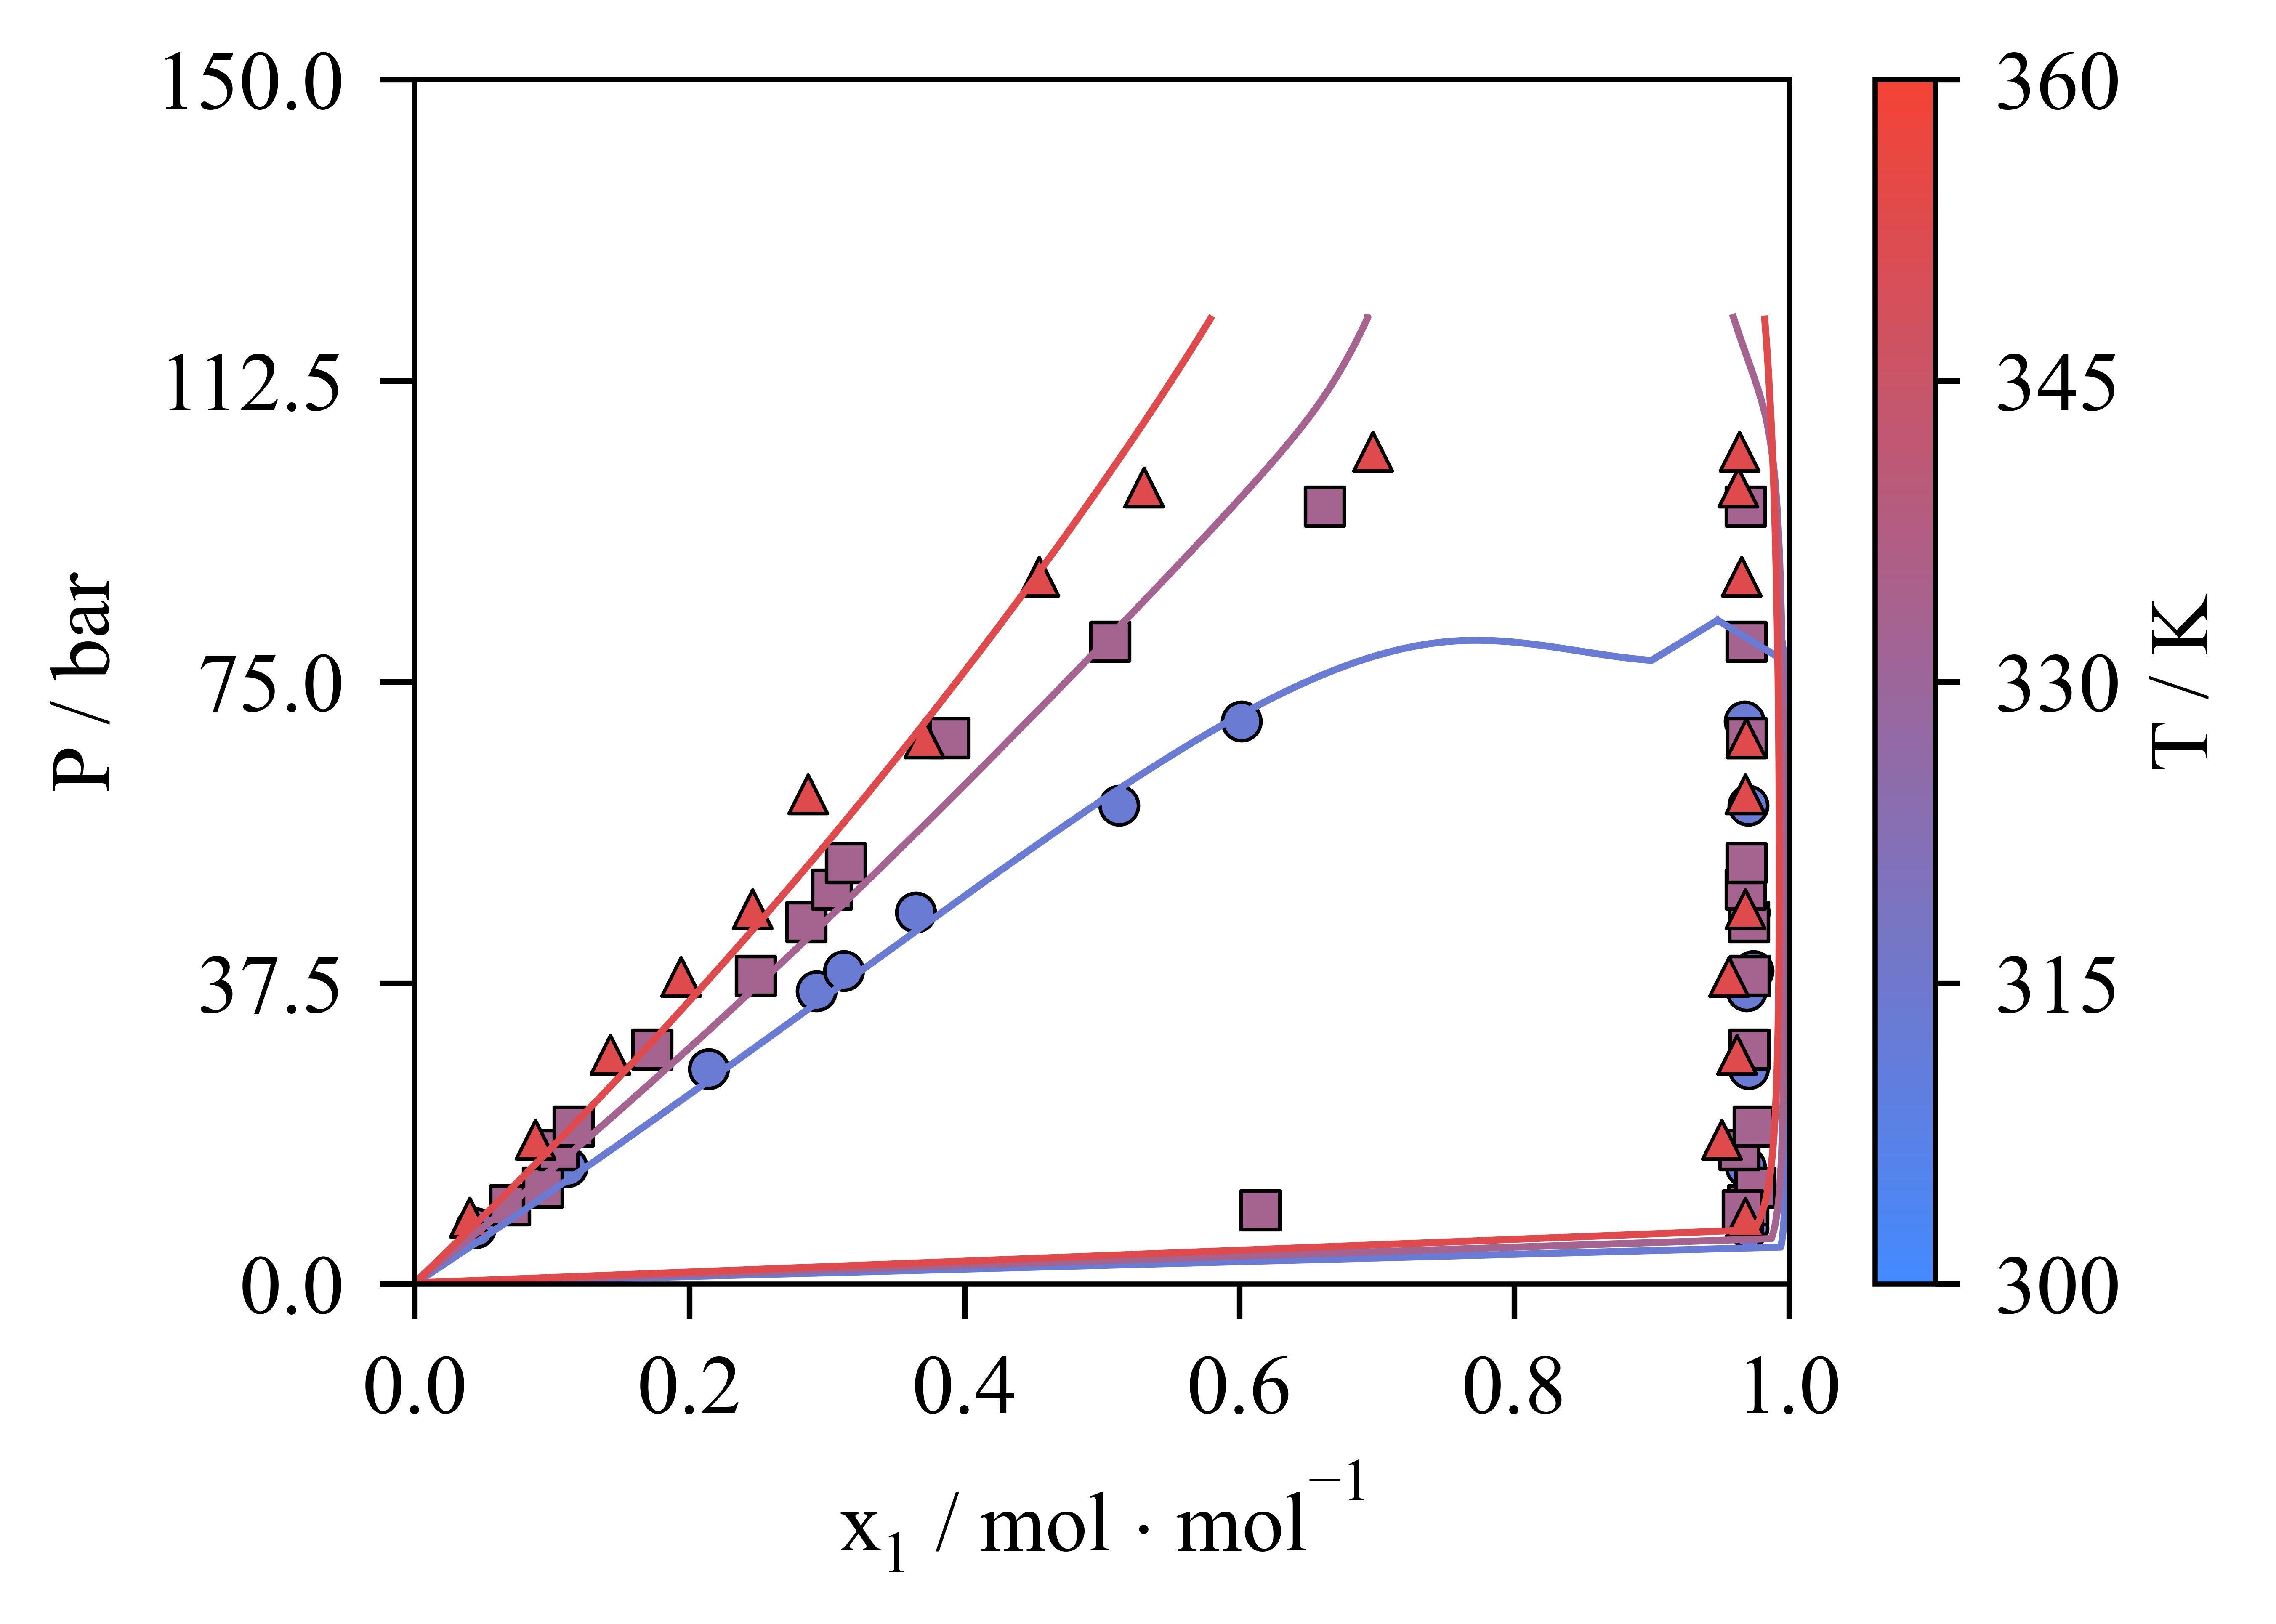

In [24]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
import matplotlib.colors as mcolors

def hex_to_RGB(hex_str):
    """ #FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]

def get_color_gradient(c1, c2, n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    """
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]
 
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Times New Roman'
matplotlib.rcParams['mathtext.it'] = 'Times New Roman'
matplotlib.rcParams['mathtext.bf'] = 'Times New Roman'
matplotlib.rcParams['xtick.major.pad']='5'
matplotlib.rcParams['ytick.major.pad']='5'
matplotlib.rcParams['axes.linewidth'] = 0.75
matplotlib.rcParams['axes.axisbelow'] = True
matplotlib.rcParams['savefig.dpi'] = 1200

font = {'weight' : 'normal', 'size'   : 12, 'family' : "Times New Roman"}
plt.rc('font', **font)
plt.rc('axes', titlesize=font["size"])


color1 = '#448AFF'
color2 = "#F44336"

Tmin = round(min(T_list)/10/2 - 0.5,0) * 10 * 2
Tmax = round(max(T_list)/10/2 + 0.5,0) * 10 * 2

n = int(Tmax - Tmin + 1)
colors = get_color_gradient(color1, color2, n)


cmap = mcolors.LinearSegmentedColormap.from_list('mycmap', colors)
data = np.random.rand(10, 10)
fig, ax = plt.subplots()
im = ax.imshow(data, cmap=cmap, vmin=Tmin, vmax=Tmax)
cb = plt.colorbar(im, ax=ax)
cb.ax.tick_params(colors='black', labelsize=12)
plt.close()

 
symbols = ['o', 's', '^', 'D']

fig, ax = plt.subplots( figsize=(3.93701 + 0.5, 3.1496), dpi=1200)


for i in range(n_T):
    color = colors[int(T_list[i] - Tmin)]
    ax.plot(out_pc["x1"][i], out_pc["P"][i], color = color, linewidth = 1.)
    ax.plot(out_pc["y1"][i], out_pc["P"][i], color = color, linewidth = 1.)
    ax.scatter(x1_exp[T_exp == T_list[i]], P_exp[T_exp == T_list[i]], 
               color = color, marker = symbols[i], linewidth=0.5, edgecolor='k', label = f'$T = {T_list[i]:.0f}$ K', s = 30)
    


ax.set_xlim(0, 1)
ax.set_ylim(0, Pf/1e5)
ax.set_xlabel('$x_1$ / mol $\cdot$ mol$^{-1}$')
ax.set_ylabel('$P$ / bar')
ax.xaxis.set_ticks(np.linspace(0, 1, 6))
ax.yaxis.set_ticks(np.linspace(0, 150, 5))
ax.tick_params(which='major', length=5)
ax.tick_params(which='minor', length=3)
# every 20 K colorbar
cb = plt.colorbar(im, ax=ax, ticks=np.linspace(Tmin, Tmax, 5))
cb.ax.tick_params(colors='black', labelsize=12)
cb.set_label(r'$T$ / K', fontsize=12)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()